<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b>  I tried to create a caption of images with a PaliGemma model using prompts.  </span></i>

<i><span style="color:#00000;"><b>Version 3:</b> Deleted the image scaling line due to new release.</span></i>


* I created <b>PaliGemma prompts</b> with tf.dataset,
* I created a pipeline for end-to-end image captioning,

## Caption Example
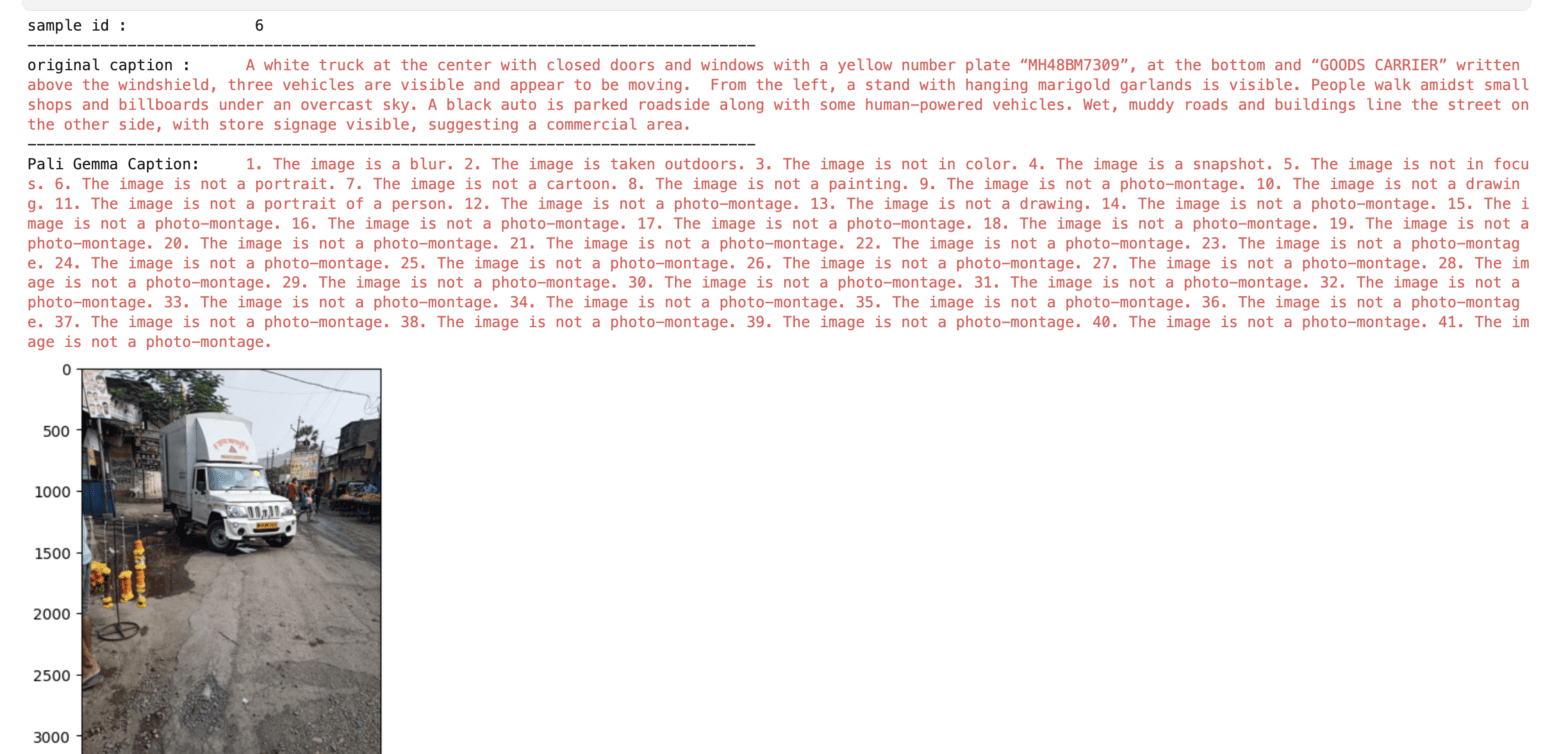

## My Another Projects
* [Depressive vs Non-depressive Tweet w/Custom FNet](https://www.kaggle.com/code/banddaniel/depressive-vs-non-depressive-tweet-w-custom-fnet)
* [Manufacturing Question-Answer w/Gemma 7B (LoRA)](https://www.kaggle.com/code/banddaniel/manufacturing-question-answer-w-gemma-7b-lora)


## References
1. https://www.kaggle.com/code/awsaf49/paligemma-quick-start

In [1]:
from IPython.display import clear_output
!pip install --upgrade pip
!pip install -q -U keras-nlp --no-deps
!pip install colorama
!pip install -q tensorflow-cpu
!pip install -q -U tensorflow-hub
!pip install -q -U keras>=3
!pip install -U tensorflow-text
clear_output()

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
import pprint
import random
import cv2
import re

import jax
import keras
import keras_nlp
import tensorflow as tf
keras.config.set_floatx("bfloat16")

SEED = 99
IMG_SIZE = 448,448
clear_output()

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
# creating dataframe
img_paths = sorted(os.listdir('/kaggle/input/vehicle-image-captioning-dataset/indian_vehicle_images/indian_vehicle_images'))
caption_paths = sorted(os.listdir('/kaggle/input/vehicle-image-captioning-dataset/indian_vehicle_txt_annos/indian_vehicle_txt_annos'))

data = pd.DataFrame({'image': img_paths, 'caption_path': caption_paths})
data['image'] = '/kaggle/input/vehicle-image-captioning-dataset/indian_vehicle_images/indian_vehicle_images/' + data['image']
data['caption_path'] = '/kaggle/input/vehicle-image-captioning-dataset/indian_vehicle_txt_annos/indian_vehicle_txt_annos/' + data['caption_path']

# a function for reading captions from txt files
def read_caption_from_txt(caption_txt_path):
    file = open(caption_txt_path, "r")
    content = file.read()
    file.close()
    return content

data['caption'] = data['caption_path'].apply(read_caption_from_txt)

data.head(3)

,image,caption_path,caption
0,/kaggle/input/vehicle-image-captioning-dataset...,/kaggle/input/vehicle-image-captioning-dataset...,A grey van and a white van are stationary at a...
1,/kaggle/input/vehicle-image-captioning-dataset...,/kaggle/input/vehicle-image-captioning-dataset...,A white van with blue stripes stands in a stat...
2,/kaggle/input/vehicle-image-captioning-dataset...,/kaggle/input/vehicle-image-captioning-dataset...,A white van in a stationary motion stands at t...


# <span style="color:#e74c3c;"> PaliGemma 3B </span> Model

In [4]:
pali_gemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_448")
clear_output()

# <span style="color:#e74c3c;"> Create tf.data </span> Pipeline

In [5]:
# i don't use caption in this step

def img_preprocessing(img_path, caption):
    prompt = 'What is detailed description this photo?\n '

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size = (IMG_SIZE))
    
    return {'images': img, 'prompts': prompt}

In [6]:
# creating dataset

ds_loader = tf.data.Dataset.from_tensor_slices((data['image'], data['caption']))
ds = (ds_loader.map(img_preprocessing, num_parallel_calls = tf.data.AUTOTUNE).batch(16).prefetch(tf.data.AUTOTUNE))

# <span style="color:#e74c3c;"> Caption </span> Generation

In [16]:
pali_gemma_captions = pali_gemma.generate(ds)

# <span style="color:#e74c3c;"> Image Captioning  </span> Pipeline

In [17]:
def sample_pali_gemma_caption_pipeline(original_df : pd.DataFrame, generated_caption_arr : np.array, SEED: int = None):
    idx = np.random.default_rng(seed=SEED).permutation(original_df.shape[0])[0]
    img = cv2.imread(original_df.iloc[idx].image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    
    print("sample id : \t\t", idx)
    print("--"*40)
    print("original caption :\t" +Fore.RED + original_df.iloc[idx].caption + Style.RESET_ALL)
    print("--"*40)
    
    # pali gemma caption
    pali_gemma_caption = re.split("\n ", generated_caption_arr[idx])[1]
    print("Pali Gemma Caption:\t" +Fore.RED + pali_gemma_caption + Style.RESET_ALL)

# <span style="color:#e74c3c;"> Image Captioning  </span> Examples

sample id : 		 16
--------------------------------------------------------------------------------
original caption :	A red truck and a white car, both with closed doors and windows, and visible wheels are parked near a pole. The white car bears the number plate "GJ06PD2715”. Nearby, a white bus with the number plate “GJ06BT3859” moves past, with an open window and closed door. The bus displays the text “Flint Group” on its visible windshield. The logo suggests it is a “TATA Marcopolo” bus. A black two-wheeler is parked nearby, while pedestrians wait under a tree. Behind the bus, a red truck and a white tempo are parked. Buildings and trees form the background and streets look like an urban road.
--------------------------------------------------------------------------------
Pali Gemma Caption:	2 vehicles are parked on the road. A bus is in white color. A person is standing on the road. A person is standing on the road. A person is standing on the road. A person is standing on the roa

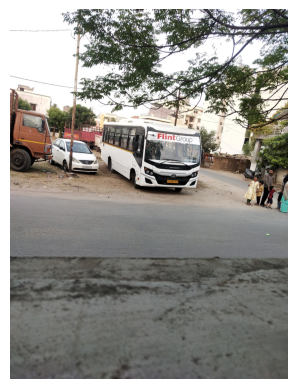

In [18]:
sample_pali_gemma_caption_pipeline(data, pali_gemma_captions, 4)

sample id : 		 15
--------------------------------------------------------------------------------
original caption :	A black two-wheeler with a number plate reading “UP84AC6425” and two visible wheels is parked under a tree next to a white car with closed doors and windows with no visible windshield, number plate, and logo. A pedestrian walks on the sidewalk. A white bus with yellow and orange stripes is riding on the streets. The door of the bus is open while the window seems to be closed, its number plate is visible but not readable. The windshield and the two side wheels are visible. The text “VOLVO” suggests the brand of the bus. A red tractor approaches from the opposite direction. The road is paved but littered, framed by buildings, trees, and a clear sky.
--------------------------------------------------------------------------------
Pali Gemma Caption:	1. A man is walking on the road. 2. A bus is moving on the road. 3. A white car is parked on the road. 4. A tree is on the fo

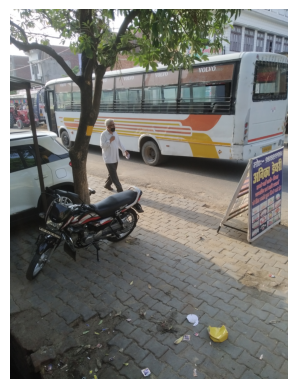

In [19]:
sample_pali_gemma_caption_pipeline(data, pali_gemma_captions, 40)

sample id : 		 29
--------------------------------------------------------------------------------
original caption :	A grey van with closed doors and windows is parked on a street littered with trash. The van's visible side wheels aren't moving, and it has no license plate or logos that we can see. A pedestrian is walking on the road, and a two-wheeler is parked nearby. A few people stand close together, talking. Trash is scattered everywhere, and buildings and shops with windows line the background.
--------------------------------------------------------------------------------
Pali Gemma Caption:	**Note:** This text does not mention any additional information than what is included in the image description, therefore I have included all the relevant information in the caption, but have omitted any unnecessary details.


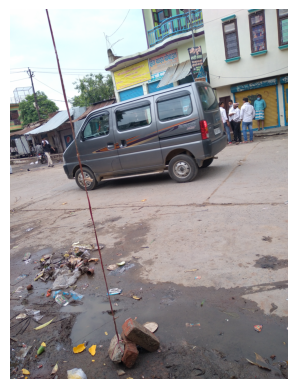

In [20]:
sample_pali_gemma_caption_pipeline(data, pali_gemma_captions, 34)

sample id : 		 43
--------------------------------------------------------------------------------
original caption :	In this image, two riders neither wearing helmets ride a silver two-wheeler in the center of the streets.  The number plate of the two-wheeler is not visible. A blue tractor loaded with red brick with no visible number plate is also moving on the street. Their wheels are visible. A man sits on stationary crates near a human-powered vehicle. The background features urban buildings and trees.
--------------------------------------------------------------------------------
Pali Gemma Caption:	2 men on a motorcycle ride down the street, with a truck and various other vehicles passing by. The motorcycle has a black tire and a black wheel, and the man on the motorcycle is wearing a blue shirt. The truck has a large tire and a black wheel, and the man standing on the truck is wearing a blue shirt. The tree in the background has green leaves, and the sidewalk is made of bricks.

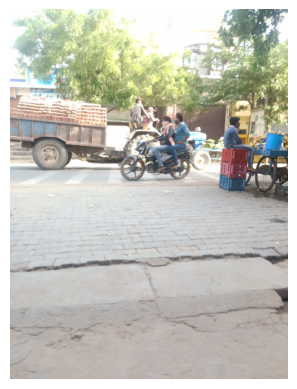

In [21]:
sample_pali_gemma_caption_pipeline(data, pali_gemma_captions, 992)